# Integration of ZarrDataset with PyTorch's DataLoader (Advanced)

In [1]:
import zarrdataset as zds

import torch
from torch.utils.data import DataLoader, ChainDataset
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(478963)

In [2]:
# These are images from the Image Data Resource (IDR) 
# https://idr.openmicroscopy.org/ that are publicly available and were 
# converted to the OME-NGFF (Zarr) format by the OME group. More examples
# can be found at Public OME-Zarr data (Nov. 2020)
# https://www.openmicroscopy.org/2020/11/04/zarr-data.html

filenames = [
    "https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.1/6001240.zarr",
    "https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.1/6001241.zarr",
    "https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.1/6001242.zarr",
    "https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.1/6001243.zarr",
]

### Extracting patches of size 128x128x32 `voxels` from a three-dimensional image

Sample the image randomly

In [3]:
patch_size = dict(Z=32, Y=128, X=128)
patch_sampler = zds.GridPatchSampler(patch_size=patch_size)

Transform the input data from uint16 to float16 with a torchvision pre-processing pipeline

In [26]:
import torchvision

img_preprocessing = torchvision.transforms.Compose([
    zds.ToDtype(dtype=np.float16)
])

Pass the pre-processing function to ZarrDataset to be used when generating the samples.

Also, enable return of each patch positions, and the worker ID that generated each patch. 

In [51]:
my_datasets = [zds.ZarrDataset(fn,
                               transform=img_preprocessing,
                               data_group="0",
                               source_axes="TCZYX",
                               patch_sampler=patch_sampler,
                               shuffle=True,
                               return_any_label=False,
                               return_positions=True,
                               return_worker_id=True)
              for fn in filenames]

### Create a ChainDataset from a set of ZarrDatasets that can be put together a single large dataset

In [52]:
my_chain_dataset = ChainDataset(my_datasets)

Make sure the chained_zarrdataset_worker_init function is passed to the DataLoader, so the workers can initialize the dataset correctly

In [70]:
my_dataloader = DataLoader(my_chain_dataset,
                           num_workers=2,
                           worker_init_fn=zds.chained_zarrdataset_worker_init,
                           batch_size=4
                           )

In [71]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [114]:
samples = []
positions = []
wids = []
for i, (wid, pos, sample) in enumerate(my_dataloader):
    wids += [w for w in wid]
    positions += [p for p in pos]
    samples += [s for s in sample]    

    print(f"Sample {i+1} with size {sample.shape} extracted by worker {wid}")
    # print("-" * 10 + f" Difference={torch.sum(sample[0].float() - sample[1].float())}")

    if i > 3:
        # Take only five samples for illustration purposes
        break

samples = torch.cat(samples, dim=0)

Sample 1 with size torch.Size([4, 1, 2, 32, 128, 128]) extracted by worker tensor([0, 0, 0, 0])
Sample 2 with size torch.Size([4, 1, 2, 32, 128, 128]) extracted by worker tensor([1, 1, 1, 1])
Sample 3 with size torch.Size([4, 1, 2, 32, 128, 128]) extracted by worker tensor([0, 0, 0, 0])
Sample 4 with size torch.Size([4, 1, 2, 32, 128, 128]) extracted by worker tensor([1, 1, 1, 1])
Sample 5 with size torch.Size([4, 1, 2, 32, 128, 128]) extracted by worker tensor([0, 0, 0, 0])


In [115]:
samples.shape

torch.Size([20, 2, 32, 128, 128])

In [116]:
samples_grid = torchvision.utils.make_grid(samples[:, :, 0, ...])

In [117]:
samples_grid.shape

torch.Size([2, 392, 1042])

(-0.5, 1041.5, 391.5, -0.5)

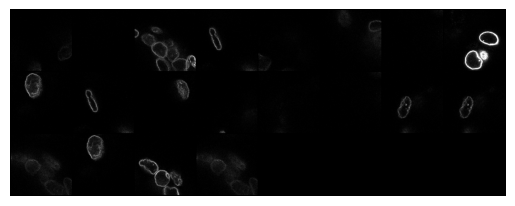

In [118]:
plt.imshow(samples_grid[0], cmap="gray")
plt.axis('off')

(-0.5, 1041.5, 391.5, -0.5)

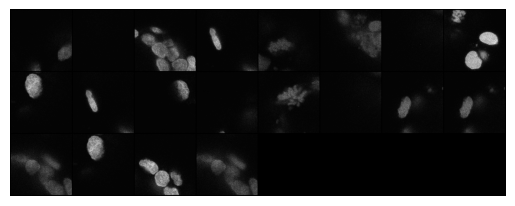

In [119]:
plt.imshow(samples_grid[1], cmap="gray")
plt.axis('off')

In [121]:
wids

[tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0)]